In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService #, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_ibm_runtime import Sampler as SamplerRT
from qiskit_ibm_runtime import Session

from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_optimization.applications import Tsp

from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA

from qiskit.primitives import Sampler

In [2]:
pip install qiskit_ibm_provider


[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
IBMQ.load_account()

/tmp/ipykernel_2889/485379158.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [5]:
provider = IBMQ.get_provider('ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairo

In [6]:
backends = provider.backends(filters = lambda x:x.configuration().n_qubits >= 2 and not x.configuration().simulator
                             and x.status().operational==True)
backends

[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [7]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and not
                                         x.configuration().simulator and x.status().operational==True))
backend.name()

'ibmq_belem'

In [8]:
backend = provider.get_backend('ibmq_belem')

In [9]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

def qaoa_callback(count, params, mean, metadata):
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)


distance
 [[ 0. 10. 23. 12. 34.]
 [10.  0. 14. 41. 23.]
 [23. 14.  0.  6. 18.]
 [12. 41.  6.  0. 12.]
 [34. 23. 18. 12.  0.]]


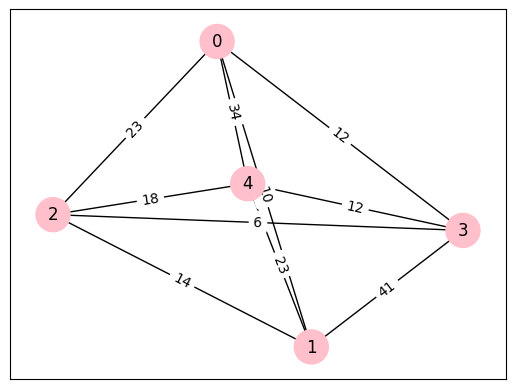

In [10]:
import math as mth
n = 5
G = nx.Graph()
G.add_nodes_from(np.arange(0,n,1))


#elist = [(0,1,3*mth.sqrt(61)), (0,2,13*mth.sqrt(5)), (0,3,25*mth.sqrt(2)),(0,4,47.42362281), (1,2,5.6381),(1,3,11.9246), (1,4,23.9929), (2,3,6.2865),(2,4,18.3547), (3,4,12.0683)]
elist = [(0,1,10), (0,2,23), (0,3,12),(0,4,34), (1,2,14),(1,3,41), (1,4,23), (2,3,6),(2,4,18), (3,4,12)]
#Belist= [(0,1,16.5529), (0,2,32.33910), (0,3,40.3113),(0,4,48.8774), (1,2,15.7580),(1,3,23.7583), (1,4,32.3245), (2,3,8.003),(2,4,16.5664), (3,4,8.5661)]
#Celist = [(0,1,11.1803), (0,2,24.4131), (0,3,31.6228),(0,4,40.3113), (1,2,13.2328),(1,3,20.4424), (1,4,29.1309), (2,3,7.2097),(2,4,15.8982), (3,4,8.6885)]
#Delist = [(0,1,15.2971), (0,2,20.0998), (0,3,25.9615),(0,4,35.1283), (1,2,4.8027),(1,3,10.6645), (1,4,19.8313), (2,3,5.8618),(2,4,15.0286), (3,4,9.1668)]
#Eelist = [(0,1,15.5242), (0,2,20.2237), (0,3,32.2490),(0,4,41.2311), (1,2,4.6996),(1,3,16.7249), (1,4,25.7069), (2,3,12.0253), (2,4,21.0073), (3,4,8.9820)]
#Felist = [(0,1,22.0227), (0,2,28.2843), (0,3,36.1248),(0,4,46.0977), (1,2,6.2616),(1,3,14.1021), (1,4,24.0750), (2,3,7.8405),(2,4,17.8135), (3,4,9.9729)]
#Gelist = [(0,1,14.8661), (0,2,30.8707), (0,3,39.1152),(0,4,46.1411), (1,2,16.0046),(1,3,24.2491), (1,4,31.2750), (2,3,8.2445),(2,4,15.2704), (3,4,7.0259)]
#Helist = [(0,1,11.1803), (0,2,25), (0,3,31.0161),(0,4,40.3113), (1,2,13.8197),(1,3,19.8358), (1,4,29.1309), (2,3,6.0161),(2,4,15.3113), (3,4,9.2952)]
#Ielist = [(0,1,13.6015), (0,2,20.0998), (0,3,24.7386),(0,4,33.3766), (1,2,6.4982),(1,3,11.1372), (1,4,19.7752), (2,3,4.6389),(2,4,13.2769), (3,4,8.6380)]
#Jelist = [(0,1,15.5242), (0,2,20.8806), (0,3,31.1448),(0,4,41.2311), (1,2,5.3564),(1,3,15.6206), (1,4,25.7069), (2,3,10.2642),(2,4,20.3504), (3,4,10.0862)]

G.add_weighted_edges_from(elist)

adj_matrix = nx.to_numpy_array(G)
print('distance\n', adj_matrix)

# Plot the graph
colors = ['pink' for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)

In [11]:
H=Tsp(G)
qp = H.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  10*x_0_0*x_1_1 + 10*x_0_0*x_1_4 + 23*x_0_0*x_2_1 + 23*x_0_0*x_2_4
  + 12*x_0_0*x_3_1 + 12*x_0_0*x_3_4 + 34*x_0_0*x_4_1 + 34*x_0_0*x_4_4
  + 10*x_0_1*x_1_0 + 10*x_0_1*x_1_2 + 23*x_0_1*x_2_0 + 23*x_0_1*x_2_2
  + 12*x_0_1*x_3_0 + 12*x_0_1*x_3_2 + 34*x_0_1*x_4_0 + 34*x_0_1*x_4_2
  + 10*x_0_2*x_1_1 + 10*x_0_2*x_1_3 + 23*x_0_2*x_2_1 + 23*x_0_2*x_2_3
  + 12*x_0_2*x_3_1 + 12*x_0_2*x_3_3 + 34*x_0_2*x_4_1 + 34*x_0_2*x_4_3
  + 10*x_0_3*x_1_2 + 10*x_0_3*x_1_4 + 23*x_0_3*x_2_2 + 23*x_0_3*x_2_4
  + 12*x_0_3*x_3_2 + 12*x_0_3*x_3_4 + 34*x_0_3*x_4_2 + 34*x_0_3*x_4_4
  + 10*x_0_4*x_1_0 + 10*x_0_4*x_1_3 + 23*x_0_4*x_2_0 + 23*x_0_4*x_2_3
  + 12*x_0_4*x_3_0 + 12*x_0_4*x_3_3 + 34*x_0_4*x_4_0 + 34*x_0_4*x_4_3
  + 14*x_1_0*x_2_1 + 14*x_1_0*x_2_4 + 41*x_1_0*x_3_1 + 41*x_1_0*x_3_4
  + 23*x_1_0*x_4_1 + 23*x_1_0*x_4_4 + 14*x_1_1*x_2_0 + 14*x_1_1*x_2_2
  + 41*x_1_1*x_3_0 + 41*x_1_1*x_3_2 + 23*x_1_1*x_4_0 + 23*x_1_1*x_4_2
  + 14*x_1_2*x_2_1 + 14*x_1_2*x_2_3 + 41*x_1_2*x_3_1 + 41*x_1_2*

In [12]:
backend

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
qaoa_meo = MinimumEigenOptimizer(qaoa)

In [20]:
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, transpile, execute

# ... (código anterior) ...

# Seleccionar la computadora cuántica ibmq_belem
backend = provider.get_backend('ibmq_qasm_simulator')

#qaoa_result = qaoa_meo.solve(qp)

# Enviar el trabajo a la computadora cuántica
#job = execute(qp, backend=backend)

# Define tu circuito QAOA para resolver el problema QP
#qaoa_circuit = QuantumCircuit(2)  # Define tu circuito aquí

# Transpila el circuito para el backend seleccionado
transpiled_circuit = transpile(qaoa, backend=backend)

# Ejecuta el circuito en la computadora cuántica
job = execute(transpiled_circuit, backend=backend)

# Esperar a que se complete el trabajo
job_result = job.result()

# Obtener los resultados
results = job_result.get_counts()

# Imprimir los resultados
print(results)

Traceback (most recent call last):
  Cell In[20], line 18
    transpiled_circuit = transpile(qaoa, backend=backend)
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:331 in transpile
    output_name = _parse_output_name(output_name, circuits)
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:586 in _parse_output_name
    return [circuit.name for circuit in circuits]
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:586 in <listcomp>
    return [circuit.name for circuit in circuits]
AttributeError: 'QAOA' object has no attribute 'name'

Use %tb to get the full traceback.


In [ ]:
qaoa_result = qaoa_meo.solve(qp)
print(qaoa_result)

In [ ]:
z = H.interpret(qaoa_result.x)
print('solution:', z)
print('solution objective:', H.tsp_value(z, adj_matrix))

In [ ]:
draw_tsp_solution(tsp.graph, z, colors, pos)